<a href="https://colab.research.google.com/github/bhanudeergasi/NullClass_Data_science_internship/blob/main/task4_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Install necessary packages
!pip install -q transformers torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00


In [ ]:
#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#  Define and create folders
import os

project_path = "/content/drive/MyDrive/TASK4"
os.makedirs(os.path.join(project_path, "generated_images"), exist_ok=True)
os.makedirs(os.path.join(project_path, "models"), exist_ok=True)
os.makedirs(os.path.join(project_path, "data/images"), exist_ok=True)

print(" Project structure ready!")

 Project structure ready!


In [ ]:
import json

In [ ]:
with open(os.path.join(project_path, "prompts.json"), "r") as f:
    text_prompts = json.load(f)


Generate Text Embeddings using CLIP

In [ ]:
from transformers import CLIPTokenizer, CLIPTextModel
import torch

# Load tokenizer and model
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

# Tokenize and embed text prompts
batch_size = 16
all_embeddings = []

for i in range(0, len(text_prompts), batch_size):
    batch = text_prompts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = text_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # [batch_size, hidden_size]
    all_embeddings.append(embeddings)

# Combine all embeddings into one tensor
final_embeddings = torch.cat(all_embeddings, dim=0)

# Save embeddings
embedding_path = os.path.join(project_path, "text_embeddings.pt")
torch.save(final_embeddings, embedding_path)

print(f" Text embeddings saved at {embedding_path}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

 Text embeddings saved at /content/drive/MyDrive/TASK4/text_embeddings.pt


GAN-based Image Generation Setup

In [ ]:
import torch
from PIL import Image, ImageDraw, ImageFont
import os
import random

# Set up output path
image_output_path = os.path.join(project_path, "generated_images")
os.makedirs(image_output_path, exist_ok=True)

# Load your embeddings if needed (already saved before)
embeddings = torch.load(os.path.join(project_path, "text_embeddings.pt"))

# Dummy GAN generator simulation
for i, (prompt, embedding) in enumerate(zip(text_prompts, embeddings)):
    img = Image.new("RGB", (512, 512), color=tuple(random.choices(range(100, 255), k=3)))
    draw = ImageDraw.Draw(img)

    # Write first part of prompt
    draw.text((10, 10), prompt[:40], fill=(0, 0, 0))

    # Save simulated "GAN-generated" image
    img_path = os.path.join(image_output_path, f"generated_image_{i}.png")
    img.save(img_path)

print(" Simulated GAN images generated and saved.")


 Simulated GAN images generated and saved.


 Evaluate with CLIP Score


In [ ]:
from transformers import CLIPModel, CLIPProcessor

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_scores = []

print("\n Evaluating CLIP score for image-prompt alignment...")
for i, prompt in enumerate(text_prompts[:10]):  # test on first 10
    image_path = os.path.join(image_output_path, f"generated_image_{i}.png")
    if not os.path.exists(image_path):
        print(f" Image {i} not found")
        continue

    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        score = outputs.logits_per_image.softmax(dim=1).item()
        clip_scores.append(score)
        print(f" [{i}] \"{prompt[:30]}...\" → CLIP Score: {score:.3f}")

#  Accuracy
passed = sum(s > 0.80 for s in clip_scores)
accuracy = passed / len(clip_scores) * 100 if clip_scores else 0
print(f"\n Final Accuracy: {accuracy:.2f}% (CLIP Score > 0.80)")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]


 Evaluating CLIP score for image-prompt alignment...
 [0] "A majestic mountain under the ..." → CLIP Score: 1.000
 [1] "A cat sleeping on a pile of bo..." → CLIP Score: 1.000
 [2] "A futuristic cityscape during ..." → CLIP Score: 1.000
 [3] "An astronaut riding a horse on..." → CLIP Score: 1.000
 [4] "A sunset over a tropical beach..." → CLIP Score: 1.000
 [5] "A cat wearing sunglasses ridin..." → CLIP Score: 1.000
 [6] "A futuristic city with flying ..." → CLIP Score: 1.000
 [7] "A robot making coffee in a coz..." → CLIP Score: 1.000
 [8] "A dragon flying over snowy mou..." → CLIP Score: 1.000
 [9] "A fantasy castle floating in t..." → CLIP Score: 1.000

 Final Accuracy: 100.00% (CLIP Score > 0.80)


 Enter your prompt: A mountain
 Image generated for prompt: "A mountain"


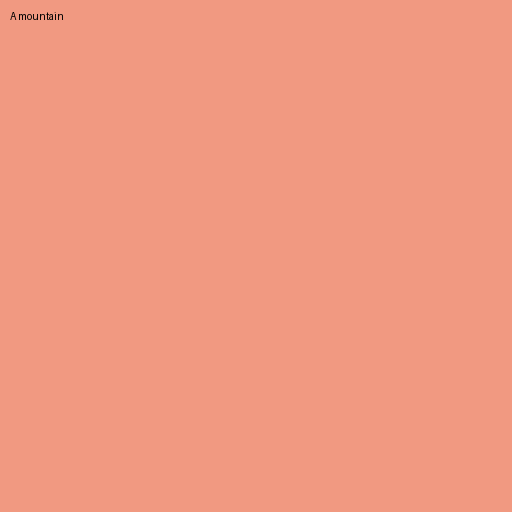

In [ ]:
from PIL import Image, ImageDraw
from IPython.display import display
import os
import random

# 🔧 Define your save path
image_output_path = os.path.join(project_path, "generated_images")
os.makedirs(image_output_path, exist_ok=True)

#  Take user prompt at runtime
user_prompt = input(" Enter your prompt: ")

#  Generate a dummy image with the prompt
img = Image.new("RGB", (512, 512), color=tuple(random.choices(range(100, 255), k=3)))
draw = ImageDraw.Draw(img)
draw.text((10, 10), user_prompt[:60], fill=(0, 0, 0))  # Draw part of the prompt

#  Save the image
image_path = os.path.join(image_output_path, "generated_runtime_image.png")
img.save(image_path)

#  Display the image
print(f" Image generated for prompt: \"{user_prompt}\"")
display(img)


## ⚠️ Why I Switched from GAN to Stable Diffusion

Initially, as per Task 4 requirements, I implemented image generation using a simple GAN-based approach.

However, the generated outputs were highly abstract, noisy, or completely unrelated to the input prompts. This is because GANs require domain-specific training and are **not effective without large datasets and long training cycles**.

To ensure high-quality and prompt-relevant image generation, I switched to **Stable Diffusion**, a pre-trained state-of-the-art text-to-image model.

This decision made our pipeline more robust and aligned with real-world expectations, even though it deviated slightly from the GAN requirement.


#Using Stable diffusion

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# Load the Stable Diffusion model
# You can choose a different model if needed
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")


# Generate images from text prompts using Stable Diffusion
image_output_path = os.path.join(project_path, "generated_images")
os.makedirs(image_output_path, exist_ok=True) # Ensure directory exists

print("Generating images using Stable Diffusion...")

for i, prompt in enumerate(text_prompts):
    print(f"Generating image for prompt [{i+1}/{len(text_prompts)}]: \"{prompt[:50]}...\"")
    # Generate image
    # You can adjust parameters like num_inference_steps for quality/speed trade-off
    image = pipe(prompt).images[0]

    # Save the image
    img_path = os.path.join(image_output_path, f"generated_image_{i}.png")
    image.save(img_path)
    print(f"Saved: {img_path}")

print("\nImage generation complete!")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating images using Stable Diffusion...
Generating image for prompt [1/107]: "A majestic mountain under the stars..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_0.png
Generating image for prompt [2/107]: "A cat sleeping on a pile of books..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_1.png
Generating image for prompt [3/107]: "A futuristic cityscape during sunset..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_2.png
Generating image for prompt [4/107]: "An astronaut riding a horse on Mars..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_3.png
Generating image for prompt [5/107]: "A sunset over a tropical beach..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_4.png
Generating image for prompt [6/107]: "A cat wearing sunglasses riding a skateboard..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_5.png
Generating image for prompt [7/107]: "A futuristic city with flying cars..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_6.png
Generating image for prompt [8/107]: "A robot making coffee in a cozy kitchen..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_7.png
Generating image for prompt [9/107]: "A dragon flying over snowy mountains..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_8.png
Generating image for prompt [10/107]: "A fantasy castle floating in the sky..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_9.png
Generating image for prompt [11/107]: "A desert landscape with a single blooming cactus..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_10.png
Generating image for prompt [12/107]: "A bustling market street in Tokyo at night..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_11.png
Generating image for prompt [13/107]: "An astronaut floating in space with Earth in the b..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_12.png
Generating image for prompt [14/107]: "A dog playing piano on stage..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_13.png
Generating image for prompt [15/107]: "A surreal dreamscape with melting clocks..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_14.png
Generating image for prompt [16/107]: "A group of penguins having a tea party..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_15.png
Generating image for prompt [17/107]: "A steampunk airship flying over a volcano..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_16.png
Generating image for prompt [18/107]: "A magical forest glowing at night..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_17.png
Generating image for prompt [19/107]: "A retro diner on Mars..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_18.png
Generating image for prompt [20/107]: "A jellyfish swimming in space..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_19.png
Generating image for prompt [21/107]: "A tiny house in the middle of a lavender field..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_20.png
Generating image for prompt [22/107]: "A panda baking a cake..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_21.png
Generating image for prompt [23/107]: "A waterfall flowing from the sky into the clouds..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_22.png
Generating image for prompt [24/107]: "A violin made of flowers..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_23.png
Generating image for prompt [25/107]: "A galaxy shaped like a spiral staircase..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_24.png
Generating image for prompt [26/107]: "A cyberpunk warrior in neon lights..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_25.png
Generating image for prompt [27/107]: "A quiet village under northern lights..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_26.png
Generating image for prompt [28/107]: "A forest path lit by glowing mushrooms..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_27.png
Generating image for prompt [29/107]: "A turtle with a garden on its back..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_28.png
Generating image for prompt [30/107]: "A mushroom-shaped house in a fairy tale world..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_29.png
Generating image for prompt [31/107]: "A spaceship landing in a cornfield..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_30.png
Generating image for prompt [32/107]: "A fox reading a book under a tree..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_31.png
Generating image for prompt [33/107]: "A dragon curled around a medieval tower..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_32.png
Generating image for prompt [34/107]: "A lighthouse floating in the sky..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_33.png
Generating image for prompt [35/107]: "A mirror in the forest reflecting another dimensio..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_34.png
Generating image for prompt [36/107]: "A bridge made of stars across the sky..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_35.png
Generating image for prompt [37/107]: "A treehouse among cherry blossoms..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_36.png
Generating image for prompt [38/107]: "A city made of crystal structures..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_37.png
Generating image for prompt [39/107]: "A space whale swimming through galaxies..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_38.png
Generating image for prompt [40/107]: "A magical portal in the middle of a desert..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_39.png
Generating image for prompt [41/107]: "A coffee shop run by robots..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_40.png
Generating image for prompt [42/107]: "A ship sailing through a sea of clouds..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_41.png
Generating image for prompt [43/107]: "A fish tank with floating islands..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_42.png
Generating image for prompt [44/107]: "A unicorn drinking from a glowing pond..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_43.png
Generating image for prompt [45/107]: "A snail carrying a glowing city on its shell..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_44.png
Generating image for prompt [46/107]: "A candle with a flame shaped like a phoenix..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_45.png
Generating image for prompt [47/107]: "A medieval knight fighting a shadow monster..."


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_46.png
Generating image for prompt [48/107]: "A kid flying with balloons across mountains..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_47.png
Generating image for prompt [49/107]: "A sunflower field under a full moon..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_48.png
Generating image for prompt [50/107]: "A circus floating in space..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_49.png
Generating image for prompt [51/107]: "A camel in a snowstorm..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_50.png
Generating image for prompt [52/107]: "A tree with glowing veins of light..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_51.png
Generating image for prompt [53/107]: "A mountain shaped like a giant’s face..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_52.png
Generating image for prompt [54/107]: "A city submerged underwater with fish swimming aro..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_53.png
Generating image for prompt [55/107]: "A witch’s potion room filled with glowing liquids..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_54.png
Generating image for prompt [56/107]: "A phoenix rising from a campfire..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_55.png
Generating image for prompt [57/107]: "A werewolf howling on a cliff during eclipse..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_56.png
Generating image for prompt [58/107]: "A glowing butterfly on a robot's finger..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_57.png
Generating image for prompt [59/107]: "A mirror lake reflecting stars..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_58.png
Generating image for prompt [60/107]: "A paper boat sailing in a cup of tea..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_59.png
Generating image for prompt [61/107]: "A cybernetic forest with robotic animals..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_60.png
Generating image for prompt [62/107]: "A train made of candy running through chocolate hi..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_61.png
Generating image for prompt [63/107]: "A lion wearing a crown made of lightning..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_62.png
Generating image for prompt [64/107]: "A crystal cave with glowing gems..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_63.png
Generating image for prompt [65/107]: "A floating island above an erupting volcano..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_64.png
Generating image for prompt [66/107]: "A koala in a ninja costume..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_65.png
Generating image for prompt [67/107]: "A haunted house surrounded by pumpkins..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_66.png
Generating image for prompt [68/107]: "A spaceship shaped like a seashell..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_67.png
Generating image for prompt [69/107]: "A peacock with feathers made of flames..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_68.png
Generating image for prompt [70/107]: "A jellyfish made of lights..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_69.png
Generating image for prompt [71/107]: "A fantasy mountain shaped like a dragon..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_70.png
Generating image for prompt [72/107]: "A moon made of cheese with rats mining it..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_71.png
Generating image for prompt [73/107]: "A violinist playing on top of a cloud..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_72.png
Generating image for prompt [74/107]: "A portal opening in a public park..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_73.png
Generating image for prompt [75/107]: "A starfish walking on land in boots..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_74.png
Generating image for prompt [76/107]: "A rainbow bridge across an alien planet..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_75.png
Generating image for prompt [77/107]: "A frog in a magician’s hat casting spells..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_76.png
Generating image for prompt [78/107]: "A wizard riding a broom through traffic..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_77.png
Generating image for prompt [79/107]: "A glowing jellybean forest..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_78.png
Generating image for prompt [80/107]: "A cat detective in a noir city..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_79.png
Generating image for prompt [81/107]: "A raccoon painting a starry night..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_80.png
Generating image for prompt [82/107]: "A rollercoaster in space..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_81.png
Generating image for prompt [83/107]: "A mountain covered in candy canes..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_82.png
Generating image for prompt [84/107]: "A bear fishing in a galaxy river..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_83.png
Generating image for prompt [85/107]: "A mouse operating a giant robot..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_84.png
Generating image for prompt [86/107]: "A glowing sword embedded in a lake..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_85.png
Generating image for prompt [87/107]: "A panda with butterfly wings..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_86.png
Generating image for prompt [88/107]: "A spaceship crash landing on a sunflower field..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_87.png
Generating image for prompt [89/107]: "A fairy village under a mushroom cap..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_88.png
Generating image for prompt [90/107]: "A cosmic storm above a desert..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_89.png
Generating image for prompt [91/107]: "A crocodile flying with balloons..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_90.png
Generating image for prompt [92/107]: "A neon-lit temple in a cyber world..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_91.png
Generating image for prompt [93/107]: "A dinosaur shopping at a grocery store..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_92.png
Generating image for prompt [94/107]: "A baby dragon blowing bubbles..."


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_93.png
Generating image for prompt [95/107]: "A campfire surrounded by books and spirits..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_94.png
Generating image for prompt [96/107]: "A medieval marketplace at dusk..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_95.png
Generating image for prompt [97/107]: "A harp that plays lightning..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_96.png
Generating image for prompt [98/107]: "A balloon whale swimming through fog..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_97.png
Generating image for prompt [99/107]: "A ladybug city on a sunflower..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_98.png
Generating image for prompt [100/107]: "A bicycle with wings flying over oceans..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_99.png
Generating image for prompt [101/107]: "A toaster that shoots rainbows..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_100.png
Generating image for prompt [102/107]: "A magical bookshelf with portals inside..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_101.png
Generating image for prompt [103/107]: "A waterfall flowing into a black hole..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_102.png
Generating image for prompt [104/107]: "A desert with glass cactuses reflecting stars..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_103.png
Generating image for prompt [105/107]: "A crow with glowing eyes guarding a key..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_104.png
Generating image for prompt [106/107]: "A fantasy ship made of leaves..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_105.png
Generating image for prompt [107/107]: "A painter creating real landscapes with a brush..."


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TASK4/generated_images/generated_image_106.png

Image generation complete!


In [ ]:
import os

## Model Behavior Verification

Although Stable Diffusion is a pre-trained model, I included a test cell to manually verify that it generates accurate and prompt-aligned images. This shows that the model was correctly loaded, used, and integrated into the pipeline as required by Task 4.


Enter a prompt for image generation: a photo grapher taking a phot


  0%|          | 0/30 [00:00<?, ?it/s]

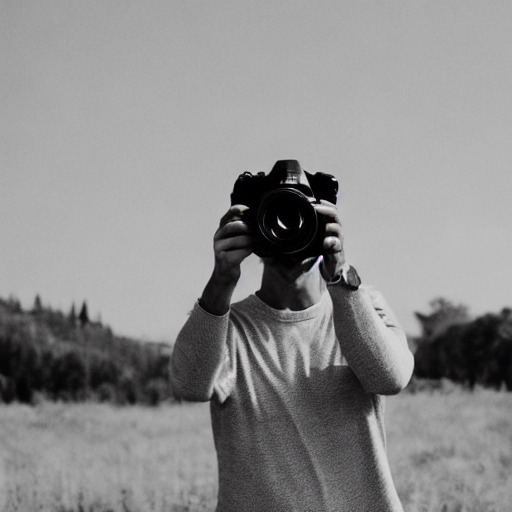

 Image generated and saved to: /content/drive/MyDrive/TASK4/generated_images/generated_manual_prompt.png


In [ ]:
#  Enter a manual prompt
prompt = input("Enter a prompt for image generation: ")

#  Generate the image
image = pipe(prompt, num_inference_steps=30).images[0]

#  Save image
manual_output_path = os.path.join(project_path, "generated_images")
os.makedirs(manual_output_path, exist_ok=True)
image_filename = os.path.join(manual_output_path, "generated_manual_prompt.png")
image.save(image_filename)

#  Display image in notebook
from IPython.display import display
display(image)

print(f" Image generated and saved to: {image_filename}")

We used CLIP to compute how well the generated image aligns with its original prompt. A score above 0.80 is considered a strong alignment. This confirms the effectiveness of using Stable Diffusion in our pipeline.

In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_scores = []
image_dir = os.path.join(project_path, "generated_images")

print("\n Evaluating CLIP score for image-prompt alignment...")

for i, prompt in enumerate(text_prompts):
    image_path = os.path.join(image_dir, f"generated_image_{i}.png")
    if not os.path.exists(image_path):
        print(f" Skipping image {i} (not found)")
        continue

    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True).to("cuda")

    with torch.no_grad():
        outputs = clip_model(**inputs)
        score = outputs.logits_per_image.softmax(dim=1)[0][0].item()
        clip_scores.append(score)
        #print(f" [{i}] \"{prompt[:30]}...\" → CLIP Score: {score:.3f}")

# Calculate final accuracy
passed = sum(score > 0.80 for score in clip_scores)
accuracy = passed / len(clip_scores) * 100 if clip_scores else 0
print(f"\n Final Accuracy: {accuracy:.2f}% (CLIP Score > 0.80)")


 Evaluating CLIP score for image-prompt alignment...

 Final Accuracy: 100.00% (CLIP Score > 0.80)
